In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

# Loading 

## Load model

In [2]:
from keras.models import load_model
model = load_model("../models/v3_newscore/model1_newscore_100_80_50.hd5")
scaler = pickle.load(open("../models/v3_newscore/scaler_model1.pkl", "rb"))

Using TensorFlow backend.
W0408 10:01:17.176747 140294300129088 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0408 10:01:17.212190 140294300129088 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0408 10:01:17.243192 140294300129088 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0408 10:01:17.244660 140294300129088 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch

## Load data
Seed is included

In [3]:
include_seed=False

In [4]:
datas_val = []

for i in range(1,51):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v4_test/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    #Seed included
    if include_seed:
        datas_val.append(d[(d.is_calo) ])
        # Seed not included
    else:
        datas_val.append(d[(d.is_calo) & (d.is_seed==False)])
    
data_ele = pd.concat(datas_val, ignore_index=True)
data_ele["particle"] = "electron"

datas_val = []

In [5]:
data_val = data_ele

# Evaluation

In [6]:
cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster", 
       "f5_r9", "f5_sigmaIetaIeta","f5_sigmaIetaIphi","f5_sigmaIphiIphi","swissCross", "nxtals"]

In [7]:
data_val["y"] = model.predict(scaler.transform(data_val[cols].values), batch_size=2048)
data_out = data_val[data_val.in_scluster== False]
data_in = data_val[data_val.in_scluster == True]

### ROC

In [5]:
# Load other rocs
import pickle
shower_results = pickle.load(open("shower_roc.pk", "rb"))
base_results = pickle.load(open("base_roc.pk", "rb"))

th_shower, fp_shower, tp_shower = shower_results
th_base, fp_base, tp_base = base_results

In [15]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve
y_test = np.array(data_val.in_scluster, dtype=int)
pred = data_val["y"].values
auc = roc_auc_score(y_test,pred)
print("AUC score: " + str(auc))


>>> Computing AUC...
AUC score: 0.9985832415931197


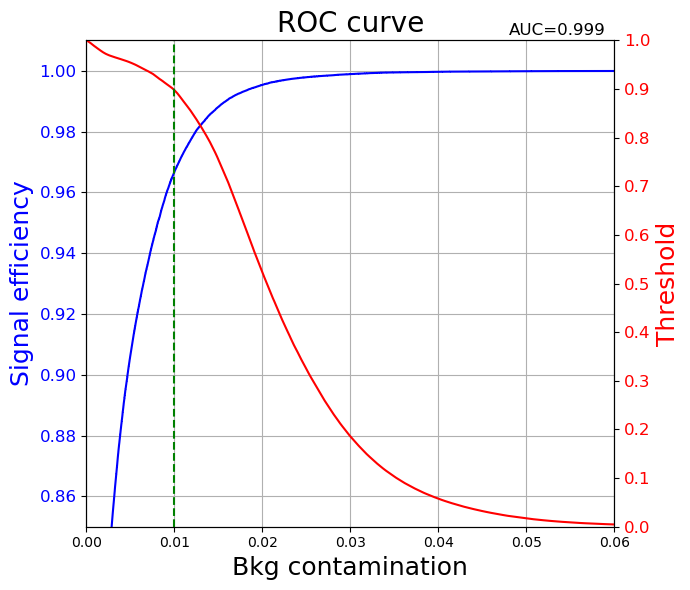

In [16]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s=f"AUC={auc:.3f}", fontsize="large")

fig.tight_layout()

In [24]:
print("threshold for 1% bkg", th[fp>= 0.01][0], "sig eff. ", tp[fp>= 0.01][0])
print("threshold for 2% bkg", th[fp>= 0.02][0], "sig eff. ", tp[fp>= 0.02][0])
print("threshold for 0.5% bkg", th[fp>= 0.005][0], "sig eff. ", tp[fp>= 0.005][0])

threshold for 1% bkg 0.8975637 sig eff.  0.9667493002203561
threshold for 2% bkg 0.52306366 sig eff.  0.9953546542790781
threshold for 0.5% bkg 0.9543456 sig eff.  0.9064603061163719


/usr/local/bin/start_ipykernel.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


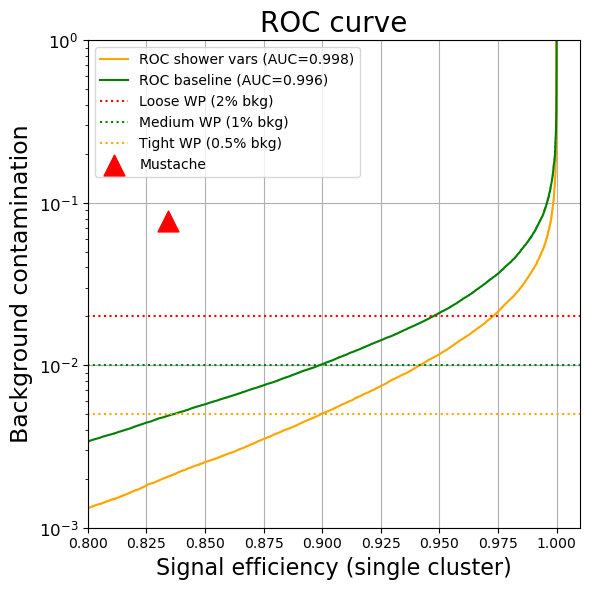

In [37]:
fp , tp, th = roc_curve(y_test, pred)

fig, ax1 = plt.subplots(figsize=(6,6), dpi=100)
#ax1.plot(tp, fp,label="ROC new assoc. (AUC={:.3f})".format(auc), color="blue")
ax1.plot(tp_shower, fp_shower,label="ROC shower vars (AUC=0.998)", color="orange")
ax1.plot(tp_base, fp_base,label="ROC baseline (AUC=0.996)", color="green")

ax1.plot((0,1.01),(0.02, 0.02), linestyle="dotted" , color="red", label="Loose WP (2% bkg)")
ax1.plot((0,1.01),(0.01, 0.01), linestyle="dotted" , color="green", label="Medium WP (1% bkg)")
ax1.plot((0,1.01),(0.005, 0.005), linestyle="dotted" , color="orange", label="Tight WP (0.5% bkg)")

ax1.set_xlabel("Signal efficiency (single cluster)", fontsize=16)
ax1.set_ylabel("Background contamination", fontsize=17)
ax1.set_ylim(0.001, 1)
ax1.set_xlim(0.8, 1.01)
ax1.set_yscale("log")
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")
ax1.scatter(0.834, 0.077, marker="^", c="red", s=15**2, label="Mustache")
#ax1.tick_params("x",labelsize="large")

ax1.set_title("ROC curve", fontsize=20)

ax1.grid("y")
#ax2.text(x = 0.048, y = 1.01, s=f"AUC={auc:.3f}", fontsize="large")
ax1.legend()
fig.tight_layout()


### Score histos

In [12]:
data_val.shape

(10345914, 25)

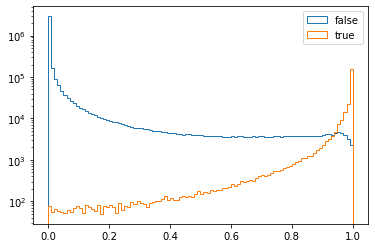

In [41]:
plt.hist(data_out["y"], bins=100, label="false", histtype="step")
plt.hist(data_in["y"], bins=100, label="true", histtype="step")
plt.yscale("log")
plt.legend()

# Plots
## Confusion matrix

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion(threshold, eta_bins, et_bins, axlim=(0.7, 0.3)):
    eta_min, eta_max = eta_bins
    et_min, et_max = et_bins
    data_out_0 = data_out[(data_out.y < threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                        (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ]
    data_out_1 = data_out[(data_out.y > threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                        (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ]
    data_in_0 = data_in[(data_in.y < threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                        (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ]
    data_in_1 = data_in[(data_in.y > threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                        (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ]
    nbins = 80
    
    fig = plt.figure(figsize=(7,8), dpi=200)

    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2, sharey = ax1)  #Share y-axes with subplot 1
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4, sharey = ax3)  #Share y-axes with subplot 1
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax4.get_yticklabels(), visible=False)
    
    #size = max([ data_out_0.size / 80**2, data_out_1.size / 80**2,data_in_0.size / 80**2, data_in_1.size / 80**2])
    
    h, *_, h11 = ax4.hist2d(data_in_1.cluster_dphi, data_in_1.cluster_deta,   
                    bins=(nbins,nbins), range=((-axlim[0], axlim[0]),(-axlim[1], axlim[1])), cmap="viridis", norm=colors.LogNorm())
    
    size = np.max(h)
    *_, h00= ax1.hist2d(data_out_0.cluster_dphi, data_out_0.cluster_deta,
                     bins=(nbins,nbins), range=((-axlim[0], axlim[0]),(-axlim[1], axlim[1])), vmax=size, cmap="viridis", norm=colors.LogNorm())
    *_, h01 = ax2.hist2d(data_out_1.cluster_dphi, data_out_1.cluster_deta,  
                     bins=(nbins,nbins), range=((-axlim[0], axlim[0]),(-axlim[1], axlim[1])), vmax=size,cmap="viridis", norm=colors.LogNorm())
    *_, h10 = ax3.hist2d(data_in_0.cluster_dphi, data_in_0.cluster_deta,  
                    bins=(nbins,nbins), range=((-axlim[0], axlim[0]),(-axlim[1], axlim[1])), vmax=size,cmap="viridis", norm=colors.LogNorm())
    
    #fig.colorbar(h00, ax=ax[0][0])
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.delaxes(cax1)
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h01, cax=cax2, label="N. clusters")
    
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    fig.delaxes(cax3)
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h11, cax=cax4, label="N. clusters")
    
    ax1.set_ylabel("$\Delta \eta$")
    ax1.set_xlabel("$\Delta \phi$")
    ax2.set_xlabel("$\Delta \phi$")
    #ax2.set_ylabel("Delta Eta")
    ax3.set_ylabel("$\Delta \eta$")
    ax3.set_xlabel("$\Delta \phi$")
    ax4.set_xlabel("$\Delta \phi$")
    #ax4.set_ylabel("Delta Eta")

    ax1.set_xlim(-axlim[0], axlim[0])
    ax2.set_xlim(-axlim[0], axlim[0])
    ax3.set_xlim(-axlim[0], axlim[0])
    ax4.set_xlim(-axlim[0], axlim[0])
    ax1.set_ylim(-axlim[1], axlim[1])
    ax2.set_ylim(-axlim[1], axlim[1])
    ax3.set_ylim(-axlim[1], axlim[1])
    ax4.set_ylim(-axlim[1], axlim[1])
    
    plt.subplots_adjust(wspace = -.015, hspace=0.25)
    #plt.tight_layout()
    fig.text(0.5, 0.9, "Background", ha="center", va="center", fontsize="large")
    fig.text(0.5, 0.48, "Signal", ha="center", va="center",fontsize="large")
    fig.text(0.13, 0.89, f"Score < {threshold}", va="center")
    fig.text(0.13, 0.47, f"Score < {threshold}",va="center")
    fig.text(0.73, 0.89, f"Score > {threshold}", va="center")
    fig.text(0.73, 0.47, f"Score > {threshold}",va="center")
    
    fig.text(0.02, 0.93, f"${eta_min} < |\eta| < {eta_max}$, ${et_min} < E_{{T}}< {et_max}$", va="center", ha="left")

KeyError: 0

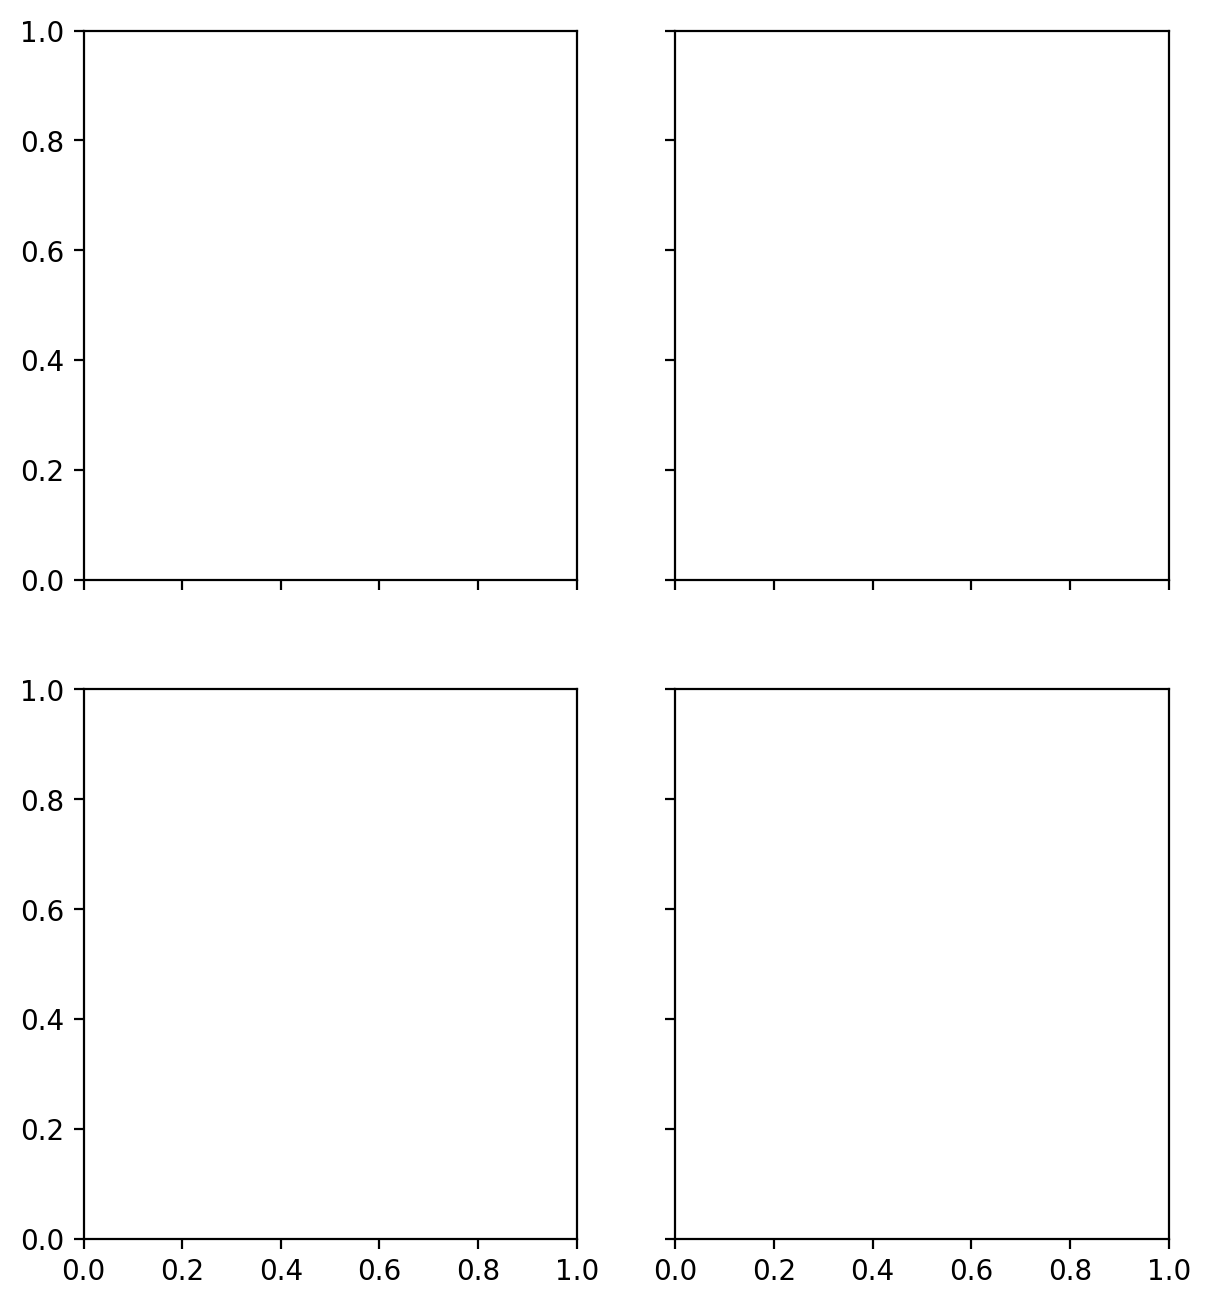

In [36]:
plot_confusion(0.898, (2.5,3), (0,100))

## Energy resolution plot

In [21]:
data_val.head()

,cluster_deta,cluster_dphi,cluster_iz,en_cluster,en_seed,en_true,f5_r9,f5_sigmaIetaIeta,f5_sigmaIetaIphi,f5_sigmaIphiIphi,...,max_en_cluster,nclusters,nxtals,seed_eta,seed_iz,seed_phi,swissCross,window_index,particle,y
0,0.002988,-0.041015,0,7.887814,89.873146,99.852600,10.852481,0.008989,0.000004,0.011641,...,89.873146,1,15,0.989136,0,0.806410,0.845659,ndpuahtb,electron,9.806811e-01
1,0.000313,-0.061987,0,6.418479,7.198207,15.215308,1.065808,0.009425,-0.000006,0.013897,...,7.198207,2,4,-0.217228,0,2.875404,0.682684,hookrmrm,electron,9.999724e-01
2,0.004441,0.096820,1,6.242136,199.011353,220.014069,24.077793,0.026348,-0.000009,0.038702,...,199.011353,1,9,1.696413,1,-1.547587,0.385677,btnkiwqo,electron,1.021326e-04
3,0.028357,-0.245550,1,3.287525,199.011353,220.014069,1.309127,0.052955,-0.000217,0.045302,...,199.011353,1,3,1.696413,1,-1.547587,0.704329,btnkiwqo,electron,0.000000e+00
4,-0.056246,-0.447001,-1,2.996015,96.244644,107.394539,2.595529,0.043348,-0.000392,0.032395,...,96.244644,1,1,-2.849090,-1,-0.790307,1.000000,vatlugxc,electron,8.940697e-08


In [22]:
thresholds = [0.4,0.7,0.8,0.85, 0.873,0.9,0.95,0.99]

results = {}

for t in thresholds:

    g = data_val[(data_val.y >  t) | (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum', 
                          "en_true": "first", 
                          "en_seed": "first",
                          "seed_eta": "first",
                          "seed_phi": "first"})
    g["ratio"] = g["en_cluster"] / g["en_true"]
    
    results[t] = g

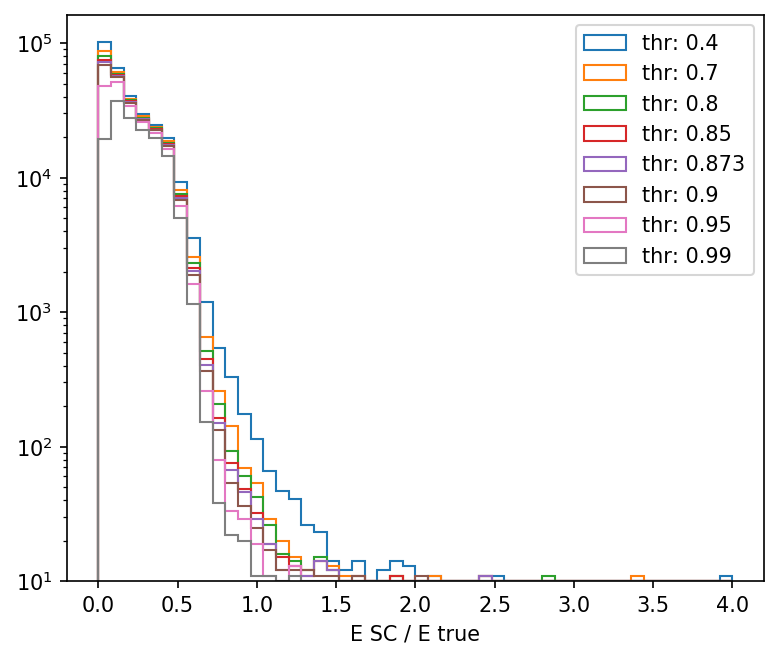

In [23]:
fig, _ = plt.subplots(figsize=(6,5), dpi=150)
for t , g in results.items():
    plt.hist(g.ratio, range=(0,4), bins=50,  histtype="step", label=f"thr: {t}", log=True, bottom=10)
plt.xlabel("E SC / E true")
plt.legend()

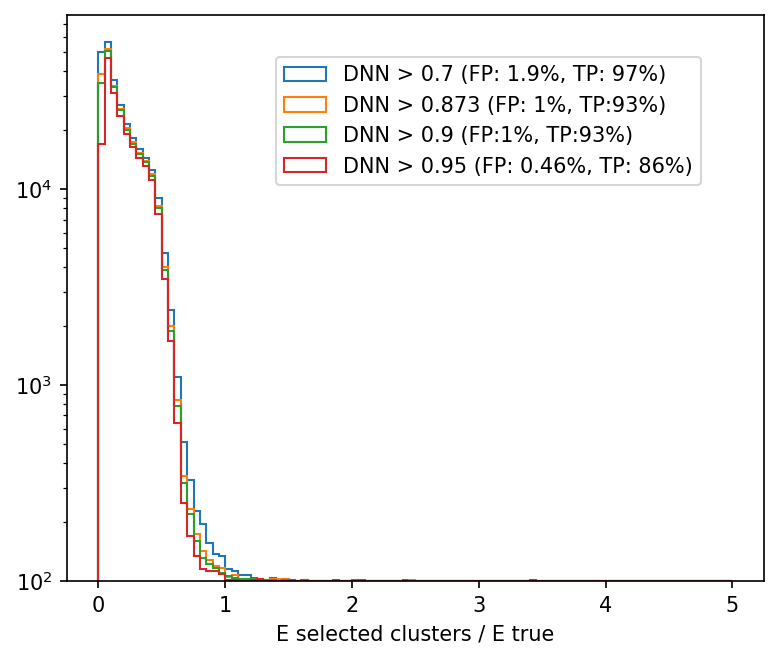

In [24]:
fig, ax = plt.subplots(figsize=(6,5), dpi=150)

info =    {
           0.7: "FP: 1.9%, TP: 97%", 
           0.873: "FP: 1%, TP:93%",
           0.9: "FP:1%, TP:93%",
           0.95: "FP: 0.46%, TP: 86%"}

for t , g in results.items():
    if t  not in [0.7, 0.873, 0.9, 0.95]: continue
    ax.hist(g.ratio, range=(0,5), bins=100,  histtype="step", label=f"DNN > {t} ({info[t]})", log=True, bottom=1e2)
ax.set_xlabel("E selected clusters / E true")
ax.legend(loc=(0.3, 0.7))

## Energy resolution scan

In [26]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


t = 0.9
g = data_val[(data_val.y >  t) | (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum', 
                          "en_true": "min", 
                          "en_seed": "first",
                          "seed_eta": "first",
                          "seed_phi": "first"})
g["ratio"] = g["en_cluster"] / g["en_true"]
g["et_seed"] = g.en_seed / np.cosh(g.seed_eta)
g["eta_bin"] = pd.cut(abs(g.seed_eta), etas)
g["en_bin"] = pd.cut(g.et_seed, ens)

scanres = g.groupby(["eta_bin", "en_bin"]).agg({"ratio": ["mean", "std"], "en_cluster": "std", "en_true": "mean"})
scanres["res"] = scanres["en_cluster", "std"] / scanres["en_true", "mean"]
resolutions = np.reshape(scanres["res"].values, (len(etas)-1, len(ens)-1))

ValueError: cannot reshape array of size 112 into shape (12,10)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)
im =  ax.imshow(resolutions, cmap="plasma_r", vmax=0.2)
ax.set_xticks(np.arange(len(ens)-1))
ax.set_yticks(np.arange(len(etas)-1))
ax.set_yticklabels(etas)
ax.set_xticklabels(ens)
ax.set_xlabel("$E_T$", fontsize="large")
ax.set_ylabel("$\eta$", fontsize="large")
plt.colorbar(im, ax=ax,label="E Supercluster resolution")

## Scores scan eta, en

In [17]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#etas = [0, 1, 2]
#ens= [0, 50, 100]
threshold = 0.9

results = np.zeros((len(etas)-1, len(ens)-1, 2))

data_in = data_in[data_in.is_seed==False]
data_out = data_out[data_out.is_seed==False]

for ieta in range(len(etas)-1):
    for ien in range(len(ens)-1):
        eta_min = etas[ieta]
        eta_max = etas[ieta+1]
        et_min = ens[ien]
        et_max = ens[ien+1]
        print(eta_min, eta_max, et_min, et_max)
        
        data_out_tot = data_out[(abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_out_1 = data_out[(data_out.y > threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_in_tot = data_in[ (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        data_in_1 = data_in[(data_in.y > threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        
        results[ieta, ien, :] = np.array([data_in_1 / data_in_tot , data_out_1 / data_out_tot])

0 0.2 0 10
0 0.2 10 20
0 0.2 20 30
0 0.2 30 40
0 0.2 40 50
0 0.2 50 60
0 0.2 60 70
0 0.2 70 80
0 0.2 80 90
0 0.2 90 100
0.2 0.4 0 10
0.2 0.4 10 20
0.2 0.4 20 30
0.2 0.4 30 40
0.2 0.4 40 50
0.2 0.4 50 60
0.2 0.4 60 70
0.2 0.4 70 80
0.2 0.4 80 90
0.2 0.4 90 100
0.4 0.6 0 10
0.4 0.6 10 20
0.4 0.6 20 30
0.4 0.6 30 40
0.4 0.6 40 50
0.4 0.6 50 60
0.4 0.6 60 70
0.4 0.6 70 80
0.4 0.6 80 90
0.4 0.6 90 100
0.6 0.8 0 10
0.6 0.8 10 20
0.6 0.8 20 30
0.6 0.8 30 40
0.6 0.8 40 50
0.6 0.8 50 60
0.6 0.8 60 70
0.6 0.8 70 80
0.6 0.8 80 90
0.6 0.8 90 100
0.8 1 0 10
0.8 1 10 20
0.8 1 20 30
0.8 1 30 40
0.8 1 40 50
0.8 1 50 60
0.8 1 60 70
0.8 1 70 80
0.8 1 80 90
0.8 1 90 100
1 1.2 0 10
1 1.2 10 20
1 1.2 20 30
1 1.2 30 40
1 1.2 40 50
1 1.2 50 60
1 1.2 60 70
1 1.2 70 80
1 1.2 80 90
1 1.2 90 100
1.2 1.4 0 10
1.2 1.4 10 20
1.2 1.4 20 30
1.2 1.4 30 40
1.2 1.4 40 50
1.2 1.4 50 60
1.2 1.4 60 70
1.2 1.4 70 80
1.2 1.4 80 90
1.2 1.4 90 100
1.4 1.479 0 10
1.4 1.479 10 20
1.4 1.479 20 30
1.4 1.479 30 40
1.4 1.479 40 50
1

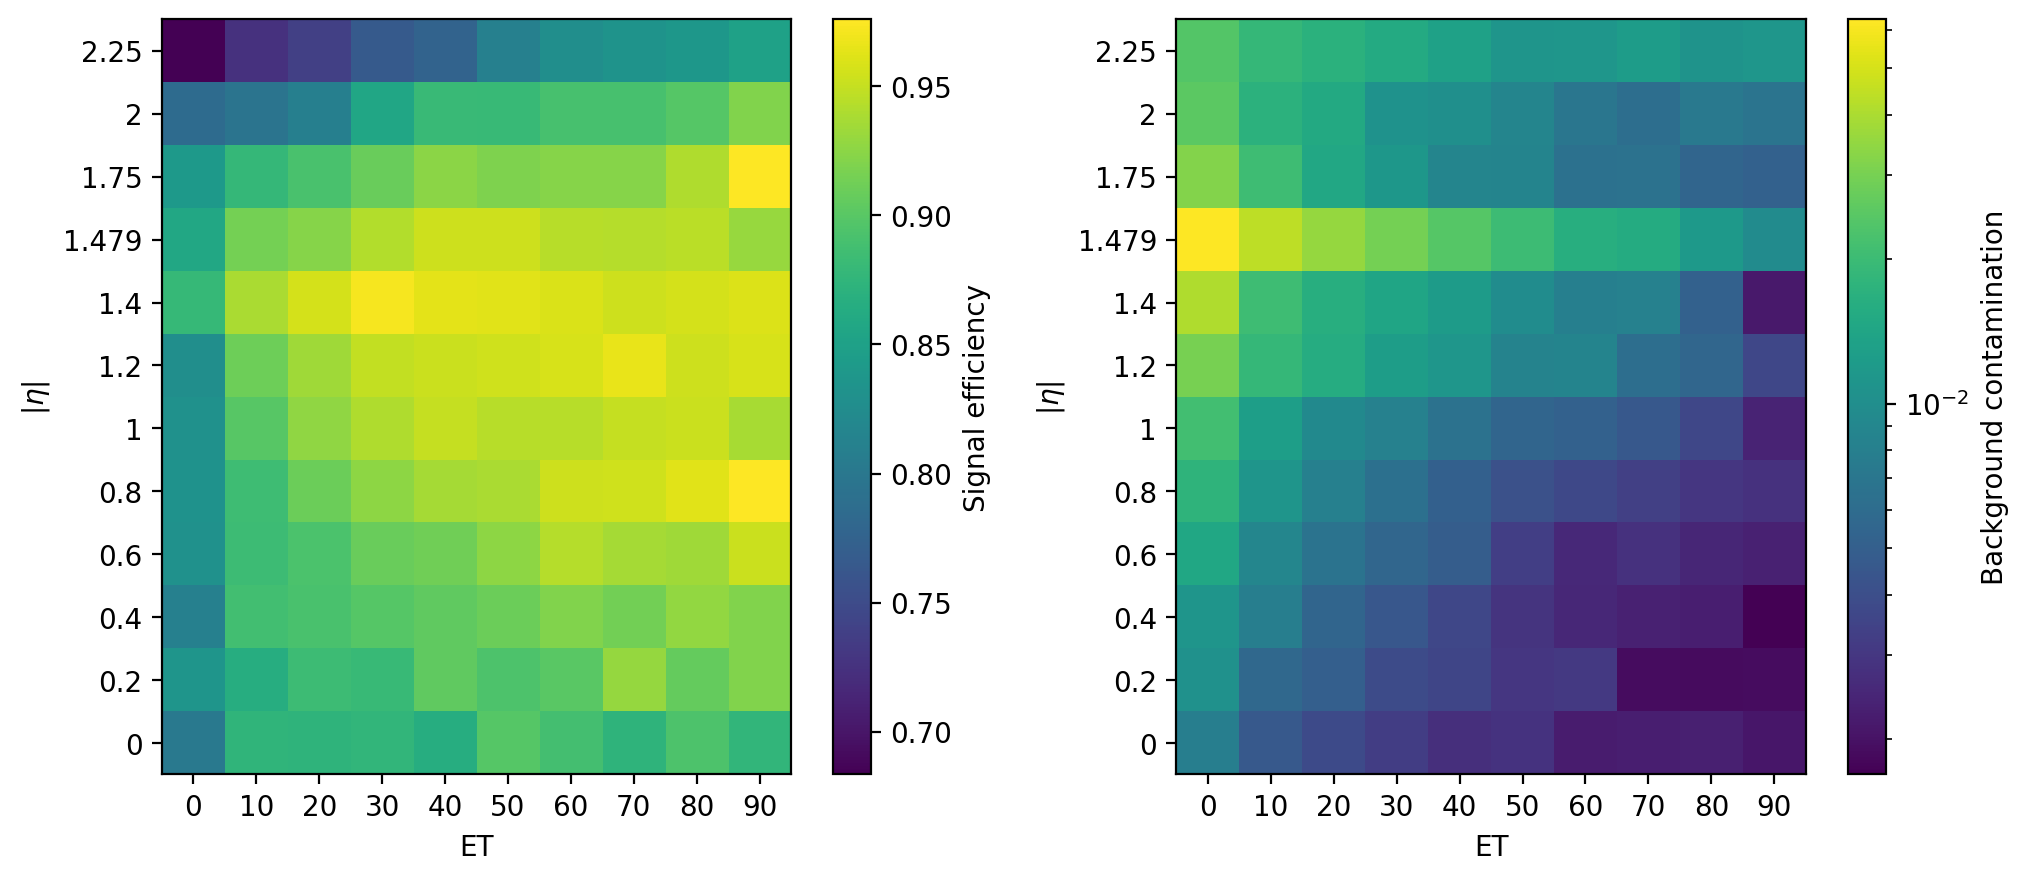

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,5), dpi=200)
im = ax1.imshow(results[:,:,0])
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1, label="Signal efficiency")

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm())
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2, label="Background contamination")

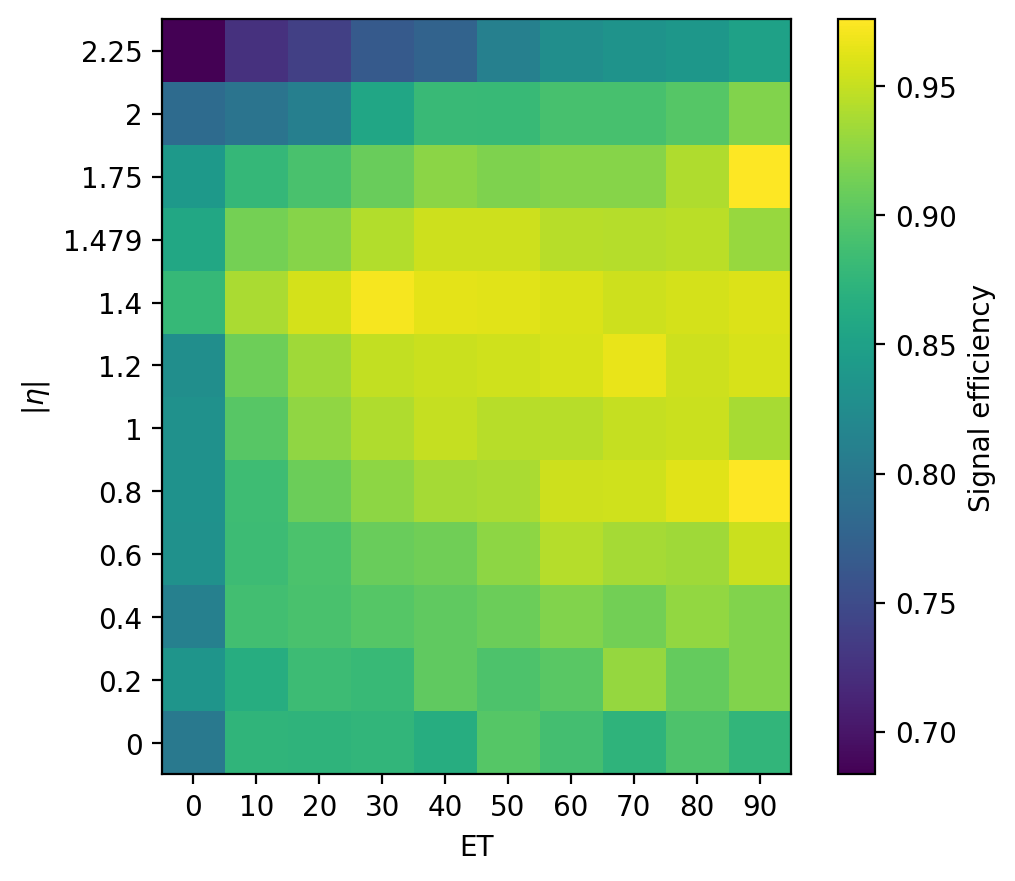

In [19]:
fig,ax1 = plt.subplots(figsize=(6,5), dpi=200)
im = ax1.imshow(results[:,:,0])
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1, label="Signal efficiency")


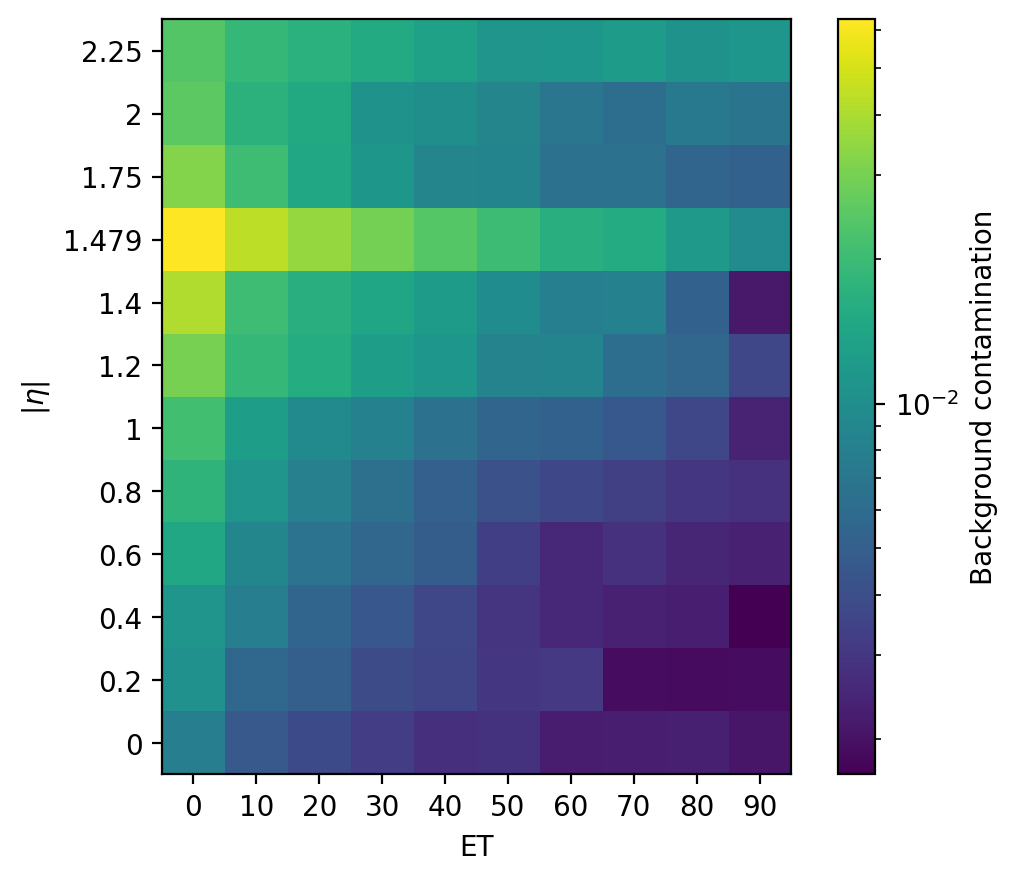

In [20]:
fig,ax2 = plt.subplots(figsize=(6,5), dpi=200)

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm())
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2, label="Background contamination")

# Scan in En seed En cluster

In [11]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0,5, 10,15, 20,25, 30,35, 40]
ens_seed = [0,10,20,30,40,50,60,70,80]

#etas = [0, 1, 2]
#ens= [0, 50, 100]
threshold = 0.9

results = np.zeros((len(ens_seed)-1, len(ens)-1, 2))

data_in = data_in[data_in.is_seed==False]
data_out = data_out[data_out.is_seed==False]

for ien_seed in range(len(ens_seed)-1):
    for ien in range(len(ens)-1):
        et_min_seed = ens_seed[ien_seed]
        et_max_seed = ens_seed[ien_seed+1]
        et_min = ens[ien]
        et_max = ens[ien+1]
        
        print(et_min_seed, et_max_seed,et_min, et_max)
        
        data_out_tot = data_out[(data_out.en_cluster > et_min ) & (data_out.en_cluster  < et_max )&
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min_seed) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max_seed) ].size
        
        
        data_out_1 = data_out[(data_out.y > threshold) & (data_out.en_cluster > et_min ) & (data_out.en_cluster < et_max )&
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min_seed) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max_seed) ].size
        
        
        data_in_tot = data_in[ (data_in.en_cluster > et_min ) & (data_in.en_cluster < et_max )&
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min_seed) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max_seed) ].size
        
       
        
        data_in_1 = data_in[(data_in.y > threshold)  & (data_in.en_cluster  > et_min ) & (data_in.en_cluster  < et_max )&
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min_seed) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max_seed) ].size
        
        
        
        results[ien_seed, ien, :] = np.array([data_in_1 / data_in_tot , data_out_1 / data_out_tot])

0 10 0 5
0 10 5 10
0 10 10 15
0 10 15 20
0 10 20 25
0 10 25 30
0 10 30 35
0 10 35 40
10 20 0 5
10 20 5 10
10 20 10 15
10 20 15 20
10 20 20 25
10 20 25 30
10 20 30 35
10 20 35 40
20 30 0 5
20 30 5 10
20 30 10 15
20 30 15 20
20 30 20 25
20 30 25 30
20 30 30 35
20 30 35 40
30 40 0 5
30 40 5 10
30 40 10 15
30 40 15 20
30 40 20 25
30 40 25 30
30 40 30 35
30 40 35 40
40 50 0 5
40 50 5 10
40 50 10 15
40 50 15 20
40 50 20 25
40 50 25 30
40 50 30 35
40 50 35 40
50 60 0 5
50 60 5 10
50 60 10 15
50 60 15 20
50 60 20 25
50 60 25 30
50 60 30 35
50 60 35 40
60 70 0 5
60 70 5 10
60 70 10 15
60 70 15 20
60 70 20 25
60 70 25 30
60 70 30 35
60 70 35 40
70 80 0 5
70 80 5 10
70 80 10 15
70 80 15 20
70 80 20 25
70 80 25 30
70 80 30 35
70 80 35 40


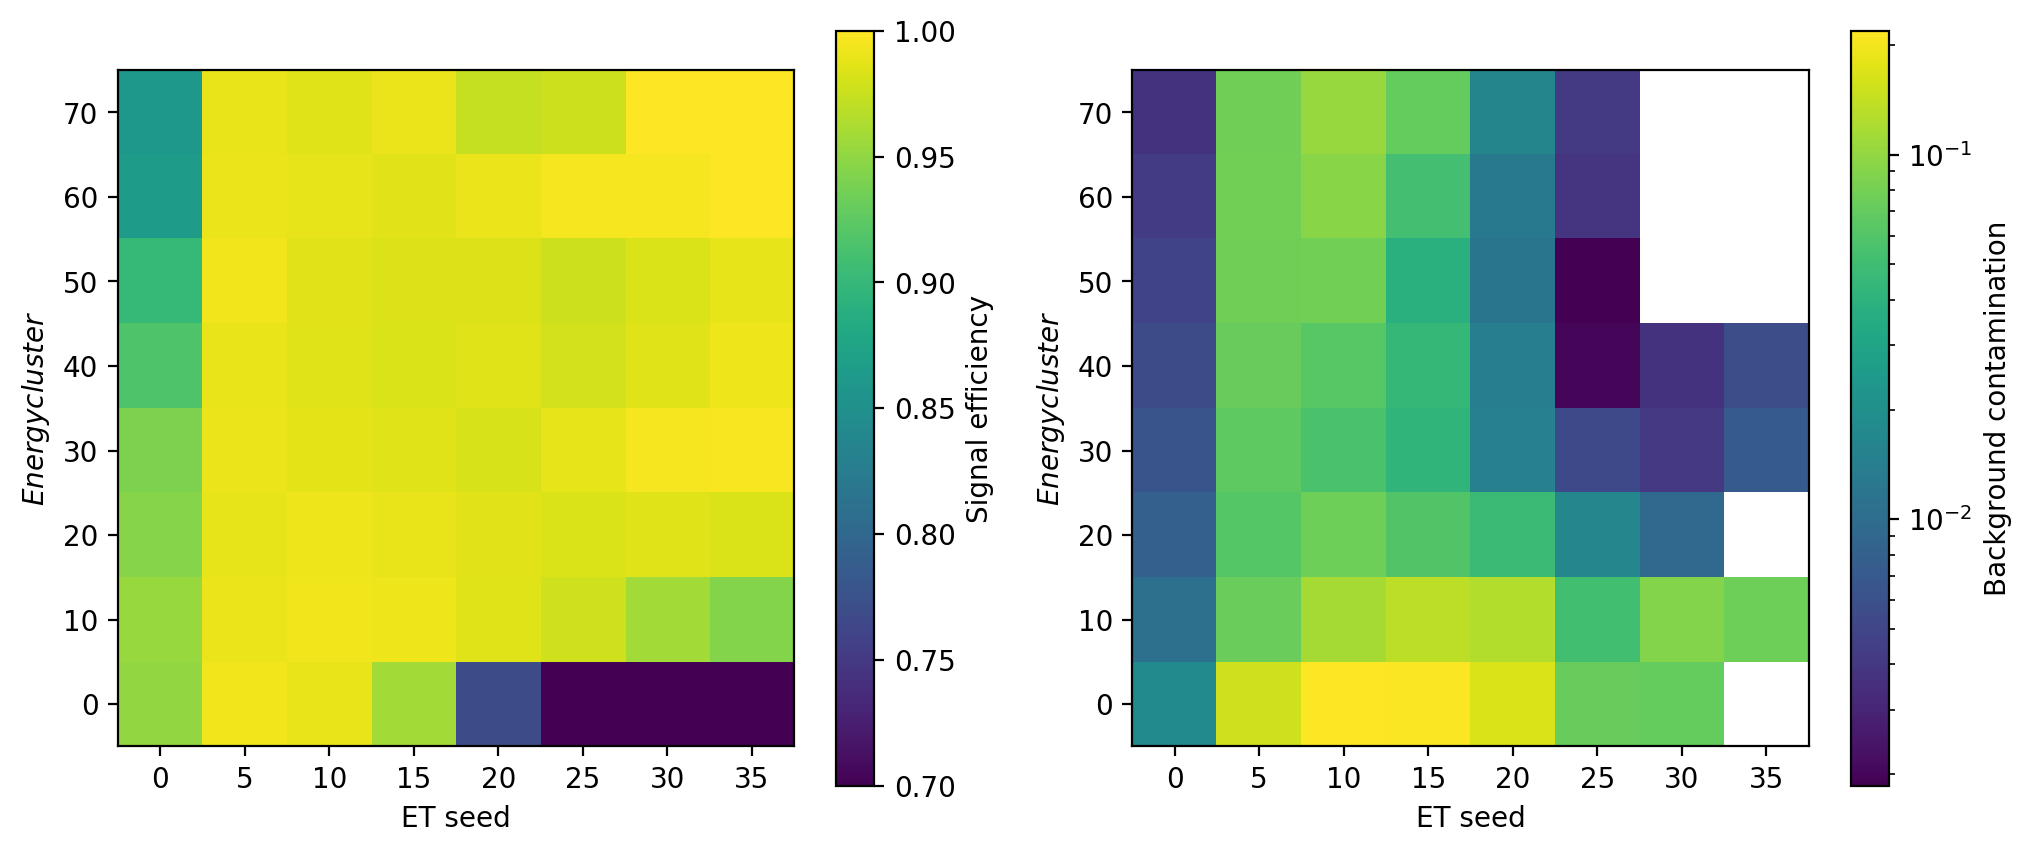

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,5), dpi=200)
im = ax1.imshow(results[:,:,0], vmin=0.7)
ax1.set_xticks(np.arange(len(ens_seed)-1))
ax1.set_yticks(np.arange(len(ens)-1))
ax1.set_yticklabels(ens_seed)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET seed")
ax1.set_ylabel("$Energy cluster$")
fig.colorbar(im, ax=ax1, label="Signal efficiency")

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm())
ax2.set_xticks(np.arange(len(ens_seed)-1))
ax2.set_yticks(np.arange(len(ens)-1))
ax2.set_yticklabels(ens_seed)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET seed")
ax2.set_ylabel("$Energy cluster$")
fig.colorbar(im2, ax=ax2, label="Background contamination")